# Task 3

The third task is about comparing your results with architectures developed using PyTorch. Compare the results obtained in Task 2 to the results obtained using the same architectures implemented in PyTorch. Then, propose improvements and new architectures that make use of more advanced methods (e.g. Convolutional Neural Networks, dropout). Compare the results.

Finally, present the confusion matrix of your best model.


## External Sources Used

- Pytorch documnetation: https://pytorch.org/docs/stable/torchvision/datasets.html#mnist and https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html About 8 lines of code were taken from the latter for the purposes of downloading and displaying samples from MNIST.

## Downloading the Dataset

In [152]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim 
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import util
from sklearn.metrics import confusion_matrix

In [2]:
# Downloading MNIST
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=2)


Size of Train set is 60000
Size of Test set is 10000

Image depicts the target: 2


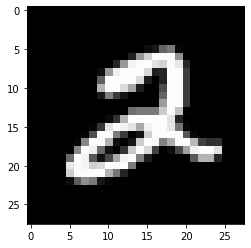

In [3]:
def display_image(image_pos=0, set=trainset):
    print(f"Image depicts the target: {set[image_pos][1]}")
    imgplot = plt.imshow(set[image_pos][0].numpy().reshape((28, 28)), cmap='gray')


print(f"\nSize of Train set is {len(trainset)}")
print(f"Size of Test set is {len(testset)}\n")

display_image(image_pos=5, set=trainset)


## The PT_NN Class

Similar to the NN class from Task 2. 

- Instantiate class
- Add layers using the add_layer method, passing in the number of nodes and the name of the desired activation function
- Fit. You can pass in the testset while fitting to print accuracy on test set every epoch.
- Evaluate using plot_loss, plot_accuracy (if the testset was passed during fitting), and score methods 

In [4]:
class PT_NN(nn.Module):
    def __init__(self, trainset, lr=1e-5):
        super(PT_NN, self).__init__()
        self.trainset = trainset
        self.n = self.trainset.data.numpy().shape[1] ** 2
        self.m = self.trainset.data.numpy().shape[0]
        self.layers = []
        self.layer_modules = []
        self.activations = []
        self.lr = lr
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        self.loss_history = []
        self.accuracy_history = []
    
    def add_layer(self, nodes=784, activation="sigmoid"):
        number_of_layers = len(self.layers)
        if number_of_layers == 0:
            layer_to_add = nn.Linear(self.n, nodes)
            self.layers.append(layer_to_add)
            self.activations.append(activation)
        else:
            prev_layer = self.layers[number_of_layers - 1]
            layer_to_add = nn.Linear(prev_layer.out_features, nodes)
            self.layers.append(layer_to_add)
            self.activations.append(activation)
        
        self.layer_modules = nn.ModuleList(self.layers)
    
    def forward_pass(self, X):
        X = X.view(-1, 784)
        for i in range(len(self.layers)):
            # print(type(self.layer_modules[i]))
            if self.activations[i] == "sigmoid":
                X = self.sigmoid(self.layer_modules[i](X))
            if self.activations[i] == "relu":
                X = self.relu(self.layer_modules[i](X))
            if self.activations[i] == "softmax":
                X = self.softmax(self.layer_modules[i](X))
        return X
    
    def fit(self, X, epochs=10, testset=None):
        calc_loss = nn.CrossEntropyLoss()
        params = self.parameters()
        optimizer = optim.SGD(params=params, lr=self.lr,)
        loss = 0
        hx = None
        for e in range(epochs):
            print(f"\nStarting epoch {e + 1}/{epochs}.")
            for i, (X, y) in enumerate(trainloader):
                hx = self.forward_pass(X)
                loss = calc_loss(hx, y)
                loss.backward() #Calc gradients
                optimizer.step() #Update params
            loss_float = float(loss)
            self.loss_history.append(float(loss))
            print(f"Loss is {loss_float}. ", end="")
            if not testset == None:
                accuracy = self.score(testset)
                self.accuracy_history.append(accuracy)
                print(f"Accuracy is {accuracy}.\n")
        
    def plot_loss(self, ymin=None, ymax=None):
        history = self.loss_history
        if ymin == None:
            plt.ylim((min(history)), (max(history)))
        else:
            plt.ylim(ymin, ymax)
        plt.title("Loss Over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.plot(list(range(len(history))), history)
        plt.show()
    
    def plot_accuracy(self, ymin=None, ymax=None):
        history = self.accuracy_history
        if len(history) == 0:
            print("Accuracy was not Recorded")
            return
        if ymin == None:
            plt.ylim((min(history)), (max(history)))
        else:
            plt.ylim(ymin, ymax)
        plt.title("Accuracy Over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.plot(list(range(len(history))), history)
        plt.show()
    
    def score(self, testset):
        total_tests = len(testset.targets)
        correct_answers = 0
        for i, (X, y) in enumerate(testloader):
            predictions = self.forward_pass(X)
            predictions = predictions.detach().numpy()
            for j in range(len(predictions)):
                p = util.decode(util.encode_probabilities(predictions[j]))
                true_target = int(y[j])
                if p == true_target:
                    correct_answers += 1
        accuracy = correct_answers / total_tests
        return accuracy
        

## Tutorial On Using the PyTorch Neural Network (PT_NN)

### Step 1: Build the Network

- Instantiate the PT_NN class, passing in your trainset and the learning rate
- Add layers using the add_layer method, passing in the number of nodes and the name of the activation function ("sigmoid", "relu", "softmax"). You only need to define the hidden and output layers.

In [5]:
pytorch_nn = PT_NN(trainset=trainset, lr=1e-3)
pytorch_nn.add_layer(nodes=100, activation="sigmoid")
pytorch_nn.add_layer(nodes=60, activation="relu")
pytorch_nn.add_layer(nodes=50, activation="sigmoid")
pytorch_nn.add_layer(nodes=10, activation="softmax")

### Step 2: Fit the Network

Call the fit method on your PT_NN object, passing in the training set, and the number of epochs you wish to train for. You may optionally pass the testset as well if you wish the network to print accuracy score after every epoch.

In [11]:
pytorch_nn.fit(trainset, epochs=50, testset=testset)


Starting epoch 1/50.
Loss is 1.9983878135681152. Accuracy is 0.5523.


Starting epoch 2/50.
Loss is 1.8910331726074219. Accuracy is 0.5594.


Starting epoch 3/50.
Loss is 1.8275775909423828. Accuracy is 0.5645.


Starting epoch 4/50.
Loss is 1.9101659059524536. Accuracy is 0.5671.


Starting epoch 5/50.
Loss is 1.8526986837387085. Accuracy is 0.6018.


Starting epoch 6/50.
Loss is 1.9044266939163208. Accuracy is 0.6021.


Starting epoch 7/50.
Loss is 1.8332562446594238. Accuracy is 0.6178.


Starting epoch 8/50.
Loss is 1.7901643514633179. Accuracy is 0.6291.


Starting epoch 9/50.
Loss is 1.778414249420166. Accuracy is 0.6391.


Starting epoch 10/50.
Loss is 1.8190813064575195. Accuracy is 0.6458.


Starting epoch 11/50.
Loss is 1.7595542669296265. Accuracy is 0.6523.


Starting epoch 12/50.
Loss is 1.7529505491256714. Accuracy is 0.6553.


Starting epoch 13/50.
Loss is 1.822860836982727. Accuracy is 0.6529.


Starting epoch 14/50.
Loss is 1.754279613494873. Accuracy is 0.6589.


Sta

### Step: Evaluate

Evaluate network performance using the methods:
- plot_loss: plots the loss over the number of epochs 
- plot_accuracy: plots the accuracy over the number of epochs (only available if youre passed the testset in while fitting)
- score: pass in your testset, this returns your networks accuracy on the set.

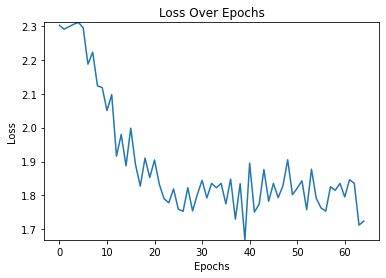

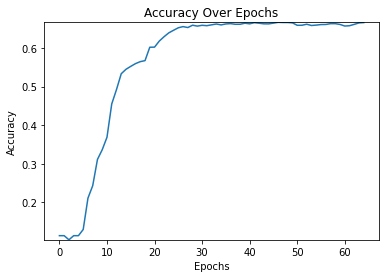

0.6657

In [12]:
pytorch_nn.plot_loss()
pytorch_nn.plot_accuracy()
pytorch_nn.score(testset=testset)

## All Sigmoid Hidden Layers


In [8]:
pt_nn_sigmoid_3 = PT_NN(trainset=trainset, lr=1e-3)
pt_nn_sigmoid_3.add_layer(nodes=100, activation="sigmoid")
pt_nn_sigmoid_3.add_layer(nodes=60, activation="sigmoid")
pt_nn_sigmoid_3.add_layer(nodes=50, activation="sigmoid")
pt_nn_sigmoid_3.add_layer(nodes=10, activation="softmax")

In [15]:
pt_nn_sigmoid_3.fit(trainset, epochs=15, testset=testset)


Starting epoch 1/15.
Loss is 1.9832963943481445. Accuracy is 0.4053.


Starting epoch 2/15.
Loss is 2.0524566173553467. Accuracy is 0.4053.


Starting epoch 3/15.
Loss is 2.0772147178649902. Accuracy is 0.4058.


Starting epoch 4/15.
Loss is 2.083430290222168. Accuracy is 0.4059.


Starting epoch 5/15.
Loss is 2.165189027786255. Accuracy is 0.4064.


Starting epoch 6/15.
Loss is 2.103619337081909. Accuracy is 0.4056.


Starting epoch 7/15.
Loss is 2.0955567359924316. Accuracy is 0.4062.


Starting epoch 8/15.
Loss is 2.109684705734253. Accuracy is 0.4061.


Starting epoch 9/15.
Loss is 2.073089361190796. Accuracy is 0.4048.


Starting epoch 10/15.
Loss is 2.0858280658721924. Accuracy is 0.4053.


Starting epoch 11/15.
Loss is 2.030684232711792. Accuracy is 0.4042.


Starting epoch 12/15.
Loss is 2.007197618484497. Accuracy is 0.4056.


Starting epoch 13/15.
Loss is 2.1548452377319336. Accuracy is 0.406.


Starting epoch 14/15.
Loss is 2.066983222961426. Accuracy is 0.4045.


Starting 

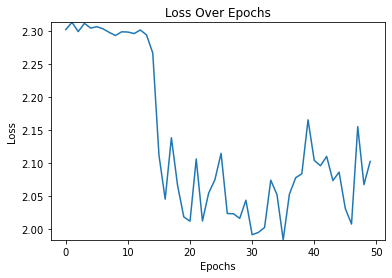

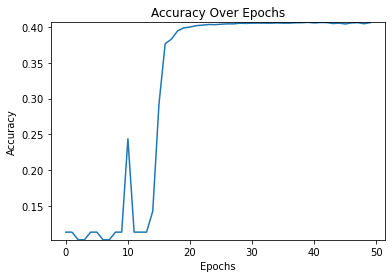

0.406

In [16]:
pt_nn_sigmoid_3.plot_loss()
pt_nn_sigmoid_3.plot_accuracy()
pt_nn_sigmoid_3.score(testset=testset)

## Two Relu/ One Sigmoid Hidden Layers

In [17]:
nn_2_relu_1_sig = PT_NN(trainset=trainset, lr=1e-3)
nn_2_relu_1_sig.add_layer(nodes=100, activation="relu")
nn_2_relu_1_sig.add_layer(nodes=60, activation="relu")
nn_2_relu_1_sig.add_layer(nodes=50, activation="sigmoid")
nn_2_relu_1_sig.add_layer(nodes=10, activation="softmax")

In [20]:
nn_2_relu_1_sig.fit(trainset, epochs=15, testset=testset)


Starting epoch 1/15.
Loss is 1.70556640625. Accuracy is 0.7319.


Starting epoch 2/15.
Loss is 1.6889063119888306. Accuracy is 0.7328.


Starting epoch 3/15.
Loss is 1.819095492362976. Accuracy is 0.7306.


Starting epoch 4/15.
Loss is 1.7606277465820312. Accuracy is 0.7308.


Starting epoch 5/15.
Loss is 1.6843624114990234. Accuracy is 0.7327.


Starting epoch 6/15.
Loss is 1.7948899269104004. Accuracy is 0.7343.


Starting epoch 7/15.
Loss is 1.6584410667419434. Accuracy is 0.7301.


Starting epoch 8/15.
Loss is 1.839859962463379. Accuracy is 0.7288.


Starting epoch 9/15.
Loss is 1.7608885765075684. Accuracy is 0.7315.


Starting epoch 10/15.
Loss is 1.748618483543396. Accuracy is 0.7296.


Starting epoch 11/15.
Loss is 1.6984061002731323. Accuracy is 0.7231.


Starting epoch 12/15.
Loss is 1.8319629430770874. Accuracy is 0.6819.


Starting epoch 13/15.
Loss is 1.6800942420959473. Accuracy is 0.6575.


Starting epoch 14/15.
Loss is 1.7818937301635742. Accuracy is 0.6967.


Starting

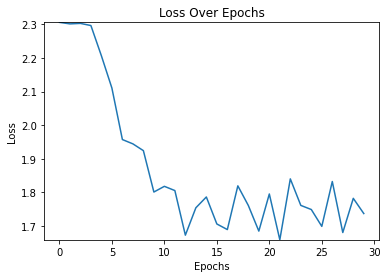

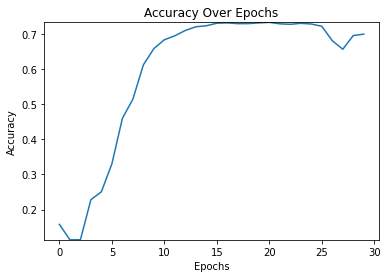

0.7006

In [21]:
nn_2_relu_1_sig.plot_loss()
nn_2_relu_1_sig.plot_accuracy()
nn_2_relu_1_sig.score(testset=testset)

## All Relu Deep Network

In [67]:
nn_5_relu = PT_NN(trainset=trainset, lr=1e-4)
nn_5_relu.add_layer(nodes=100, activation="relu")
nn_5_relu.add_layer(nodes=90, activation="relu")
nn_5_relu.add_layer(nodes=80, activation="relu")
nn_5_relu.add_layer(nodes=70, activation="relu")
nn_5_relu.add_layer(nodes=60, activation="relu")
nn_5_relu.add_layer(nodes=10, activation="softmax")

In [73]:
nn_5_relu.fit(trainset, epochs=15, testset=testset)


Starting epoch 1/15.
Loss is 1.782692790031433. Accuracy is 0.7078.


Starting epoch 2/15.
Loss is 1.6305164098739624. Accuracy is 0.7279.


Starting epoch 3/15.
Loss is 1.7632313966751099. Accuracy is 0.7151.


Starting epoch 4/15.
Loss is 1.8048783540725708. Accuracy is 0.7075.


Starting epoch 5/15.
Loss is 1.7528175115585327. Accuracy is 0.6951.


Starting epoch 6/15.
Loss is 1.8986567258834839. Accuracy is 0.6287.


Starting epoch 7/15.
Loss is 1.8465676307678223. Accuracy is 0.5838.


Starting epoch 8/15.
Loss is 1.888234257698059. Accuracy is 0.5681.


Starting epoch 9/15.
Loss is 1.919482707977295. Accuracy is 0.5624.


Starting epoch 10/15.
Loss is 1.9299010038375854. Accuracy is 0.5618.


Starting epoch 11/15.
Loss is 1.950734257698059. Accuracy is 0.5188.


Starting epoch 12/15.
Loss is 1.9194841384887695. Accuracy is 0.539.


Starting epoch 13/15.
Loss is 1.856984257698059. Accuracy is 0.5459.


Starting epoch 14/15.
Loss is 1.919484257698059. Accuracy is 0.5442.


Startin

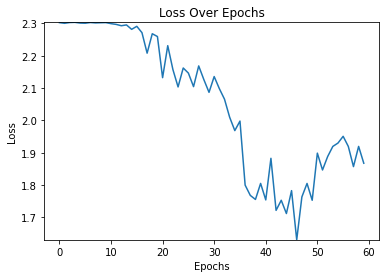

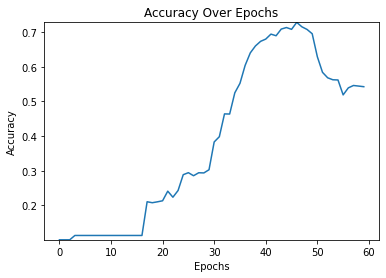

0.5424

In [74]:
nn_5_relu.plot_loss()
nn_5_relu.plot_accuracy()
nn_5_relu.score(testset=testset)

## Single Sigmoid Wide

Testing the best architecture using the Numpy Network

In [32]:
nn_wide_sig = PT_NN(trainset=trainset, lr=1e-4)
nn_wide_sig.add_layer(nodes=800, activation="sigmoid")
nn_wide_sig.add_layer(nodes=10, activation="softmax")

In [35]:
nn_wide_sig.fit(trainset, epochs=15, testset=testset)


Starting epoch 1/15.
Loss is 2.001025438308716. Accuracy is 0.4905.


Starting epoch 2/15.
Loss is 1.9700325727462769. Accuracy is 0.4903.


Starting epoch 3/15.
Loss is 1.9480409622192383. Accuracy is 0.49.


Starting epoch 4/15.
Loss is 1.97996187210083. Accuracy is 0.4904.


Starting epoch 5/15.
Loss is 1.9772905111312866. Accuracy is 0.4913.


Starting epoch 6/15.
Loss is 2.0010876655578613. Accuracy is 0.492.


Starting epoch 7/15.
Loss is 2.0107953548431396. Accuracy is 0.4927.


Starting epoch 8/15.
Loss is 1.8042415380477905. Accuracy is 0.493.


Starting epoch 9/15.
Loss is 1.9179967641830444. Accuracy is 0.4932.


Starting epoch 10/15.
Loss is 1.9399018287658691. Accuracy is 0.4936.


Starting epoch 11/15.
Loss is 1.9502496719360352. Accuracy is 0.4934.


Starting epoch 12/15.
Loss is 2.0005245208740234. Accuracy is 0.4938.


Starting epoch 13/15.
Loss is 2.086104154586792. Accuracy is 0.4937.


Starting epoch 14/15.
Loss is 1.9707287549972534. Accuracy is 0.4939.


Starting

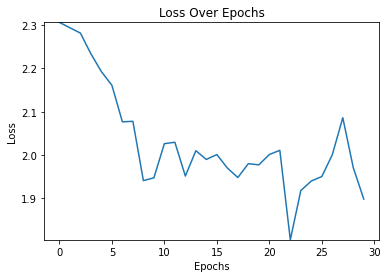

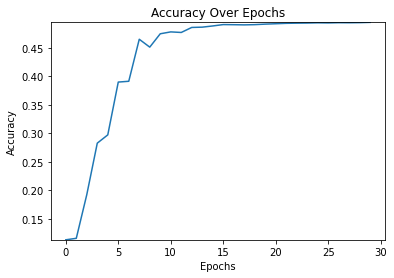

0.4944

In [36]:
nn_wide_sig.plot_loss()
nn_wide_sig.plot_accuracy()
nn_wide_sig.score(testset=testset)

## Single Relu Wide

In [37]:
nn_wide_relu = PT_NN(trainset=trainset, lr=1e-4)
nn_wide_relu.add_layer(nodes=800, activation="relu")
nn_wide_relu.add_layer(nodes=10, activation="softmax")

In [40]:
nn_wide_relu.fit(trainset, epochs=15, testset=testset)


Starting epoch 1/15.
Loss is 1.5794883966445923. Accuracy is 0.8147.


Starting epoch 2/15.
Loss is 1.628865361213684. Accuracy is 0.814.


Starting epoch 3/15.
Loss is 1.677462100982666. Accuracy is 0.8209.


Starting epoch 4/15.
Loss is 1.6904293298721313. Accuracy is 0.8258.


Starting epoch 5/15.
Loss is 1.6386851072311401. Accuracy is 0.8284.


Starting epoch 6/15.
Loss is 1.586112380027771. Accuracy is 0.8294.


Starting epoch 7/15.
Loss is 1.5956019163131714. Accuracy is 0.8285.


Starting epoch 8/15.
Loss is 1.6118769645690918. Accuracy is 0.8289.


Starting epoch 9/15.
Loss is 1.6552006006240845. Accuracy is 0.8288.


Starting epoch 10/15.
Loss is 1.6582640409469604. Accuracy is 0.8304.


Starting epoch 11/15.
Loss is 1.5861493349075317. Accuracy is 0.8305.


Starting epoch 12/15.
Loss is 1.6174407005310059. Accuracy is 0.8302.


Starting epoch 13/15.
Loss is 1.6486191749572754. Accuracy is 0.8308.


Starting epoch 14/15.
Loss is 1.608568787574768. Accuracy is 0.8312.


Start

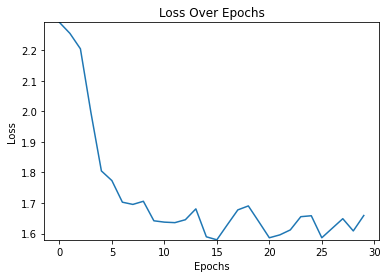

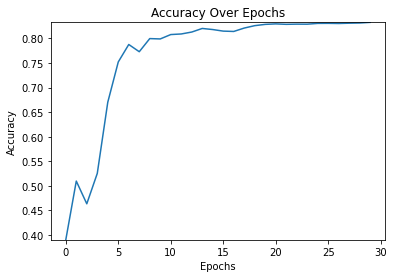

0.8325

In [41]:
nn_wide_relu.plot_loss()
nn_wide_relu.plot_accuracy()
nn_wide_relu.score(testset=testset)

## Double Relu Wide

In [93]:
nn_2_wide_relu = PT_NN(trainset=trainset, lr=1e-4)
nn_2_wide_relu.add_layer(nodes=800, activation="relu")
nn_2_wide_relu.add_layer(nodes=100, activation="relu")
nn_2_wide_relu.add_layer(nodes=10, activation="softmax")

In [97]:
nn_2_wide_relu.fit(trainset, epochs=15, testset=testset)


Starting epoch 1/15.
Loss is 1.6910649538040161. Accuracy is 0.7217.


Starting epoch 2/15.
Loss is 1.8048990964889526. Accuracy is 0.7323.


Starting epoch 3/15.
Loss is 1.7215675115585327. Accuracy is 0.7261.


Starting epoch 4/15.
Loss is 1.711145043373108. Accuracy is 0.7286.


Starting epoch 5/15.
Loss is 1.7524303197860718. Accuracy is 0.7306.


Starting epoch 6/15.
Loss is 1.783798098564148. Accuracy is 0.726.


Starting epoch 7/15.
Loss is 1.7424007654190063. Accuracy is 0.7322.


Starting epoch 8/15.
Loss is 1.7528162002563477. Accuracy is 0.7331.


Starting epoch 9/15.
Loss is 1.7632341384887695. Accuracy is 0.729.


Starting epoch 10/15.
Loss is 1.7528175115585327. Accuracy is 0.7329.


Starting epoch 11/15.
Loss is 1.6903175115585327. Accuracy is 0.7353.


Starting epoch 12/15.
Loss is 1.7319797277450562. Accuracy is 0.736.


Starting epoch 13/15.
Loss is 1.7840676307678223. Accuracy is 0.7334.


Starting epoch 14/15.
Loss is 1.7632341384887695. Accuracy is 0.7308.


Start

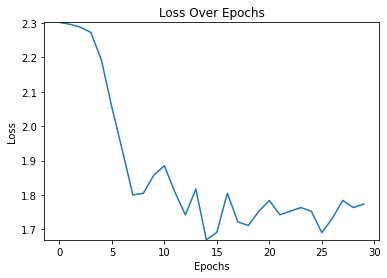

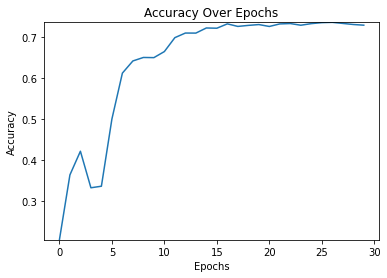

0.7291

In [98]:
nn_2_wide_relu.plot_loss()
nn_2_wide_relu.plot_accuracy()
nn_2_wide_relu.score(testset=testset)

## Deep and Wide Relu

In [42]:
nn_huge_relu = PT_NN(trainset=trainset, lr=1e-4)
nn_huge_relu.add_layer(nodes=800, activation="relu")
nn_huge_relu.add_layer(nodes=800, activation="relu")
nn_huge_relu.add_layer(nodes=800, activation="relu")
nn_huge_relu.add_layer(nodes=800, activation="relu")
nn_huge_relu.add_layer(nodes=800, activation="relu")
nn_huge_relu.add_layer(nodes=10, activation="softmax")

In [45]:
nn_huge_relu.fit(trainset, epochs=15, testset=testset)


Starting epoch 1/15.
Loss is 2.2554497718811035. Accuracy is 0.2381.


Starting epoch 2/15.
Loss is 2.1648497581481934. Accuracy is 0.333.


Starting epoch 3/15.
Loss is 2.0811145305633545. Accuracy is 0.3986.


Starting epoch 4/15.
Loss is 2.00970196723938. Accuracy is 0.4969.


Starting epoch 5/15.
Loss is 2.0018131732940674. Accuracy is 0.5483.


Starting epoch 6/15.
Loss is 1.808097243309021. Accuracy is 0.583.


Starting epoch 7/15.
Loss is 1.7968262434005737. Accuracy is 0.6069.


Starting epoch 8/15.
Loss is 1.8253669738769531. Accuracy is 0.6202.


Starting epoch 9/15.
Loss is 1.877817153930664. Accuracy is 0.6386.


Starting epoch 10/15.
Loss is 1.8983157873153687. Accuracy is 0.6442.


Starting epoch 11/15.
Loss is 1.794484257698059. Accuracy is 0.6414.


Starting epoch 12/15.
Loss is 1.8049007654190063. Accuracy is 0.6446.


Starting epoch 13/15.
Loss is 1.8049010038375854. Accuracy is 0.629.


Starting epoch 14/15.
Loss is 1.8361510038375854. Accuracy is 0.5969.


Starting

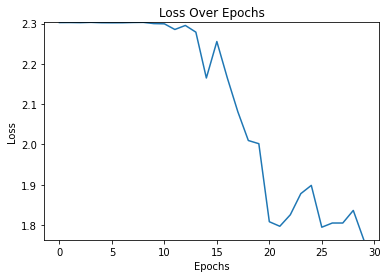

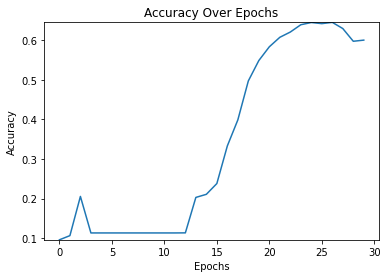

0.5998

In [46]:
nn_huge_relu.plot_loss()
nn_huge_relu.plot_accuracy()
nn_huge_relu.score(testset=testset)

## Improving the Best Architecture

In [191]:
class PT_NN_Best(nn.Module):
    def __init__(self):
        super(PT_NN_Best, self).__init__()
        #Layers
        self.l1 = nn.Linear(784, 800)
        self.l2 = nn.Linear(800, 10)
        #Functions
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        self.dropout = nn.Dropout(0.05)
        #Learning Rate
        #History
        self.loss_history = []
        self.accuracy_history = []
    
    def forward_pass(self, X):
        X = X.view(-1, 784)
        X = self.relu(self.l1(X))
        X = self.dropout(X)
        X = self.softmax(self.l2(X))
        return X
    
    def fit(self, X, epochs=10, testset=None, lr=1e-5):
        calc_loss = nn.CrossEntropyLoss()
        params = self.parameters()
        optimizer = optim.SGD(params=params, lr=lr)
        loss = 0
        hx = None
        for e in range(epochs):
            print(f"\nStarting epoch {e + 1}/{epochs}.")
            for i, (X, y) in enumerate(trainloader):
                hx = self.forward_pass(X)
                loss = calc_loss(hx, y)
                loss.backward() #Calc gradients
                optimizer.step() #Update params
            loss_float = float(loss)   
            self.loss_history.append(float(loss))
            print(f"Loss is {loss_float}. ", end="")
            if not testset == None:
                accuracy = self.score(testset)
                self.accuracy_history.append(accuracy)
                print(f"Accuracy is {accuracy}.\n")
        
    def plot_loss(self, ymin=None, ymax=None):
        history = self.loss_history
        if ymin == None:
            plt.ylim((min(history)), (max(history)))
        else:
            plt.ylim(ymin, ymax)
        plt.title("Loss Over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.plot(list(range(len(history))), history)
        plt.show()
    
    def plot_accuracy(self, ymin=None, ymax=None):
        history = self.accuracy_history
        if len(history) == 0:
            print("Accuracy was not Recorded")
            return
        if ymin == None:
            plt.ylim((min(history)), (max(history)))
        else:
            plt.ylim(ymin, ymax)
        plt.title("Accuracy Over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.plot(list(range(len(history))), history)
        plt.show()
    
    def score(self, testset, return_predictions=False):
        total_tests = len(testset.targets)
        correct_answers = 0
        model_predictions = []
        true_targets = []
        for i, (X, y) in enumerate(testloader):
            predictions = self.forward_pass(X)
            predictions = predictions.detach().numpy()
            for j in range(len(predictions)):
                p = util.decode(util.encode_probabilities(predictions[j]))
                true_target = int(y[j])
                model_predictions.append(p)
                true_targets.append(true_target)
                if p == true_target:
                    correct_answers += 1
        accuracy = correct_answers / total_tests
        if return_predictions:
            return model_predictions, true_targets
        return accuracy
        

In [192]:
best_nn = PT_NN_Best()

In [195]:
best_nn.fit(trainset, epochs=10, testset=testset, lr=1e-5)


Starting epoch 1/10.
Loss is 1.6694835424423218. Accuracy is 0.837.


Starting epoch 2/10.
Loss is 1.6407426595687866. Accuracy is 0.8375.


Starting epoch 3/10.
Loss is 1.6068944931030273. Accuracy is 0.8371.


Starting epoch 4/10.
Loss is 1.6590615510940552. Accuracy is 0.8372.


Starting epoch 5/10.
Loss is 1.5861507654190063. Accuracy is 0.838.


Starting epoch 6/10.
Loss is 1.6278166770935059. Accuracy is 0.8371.


Starting epoch 7/10.
Loss is 1.669084906578064. Accuracy is 0.838.


Starting epoch 8/10.
Loss is 1.5861507654190063. Accuracy is 0.8381.


Starting epoch 9/10.
Loss is 1.6705437898635864. Accuracy is 0.8385.


Starting epoch 10/10.
Loss is 1.7111507654190063. Accuracy is 0.8381.



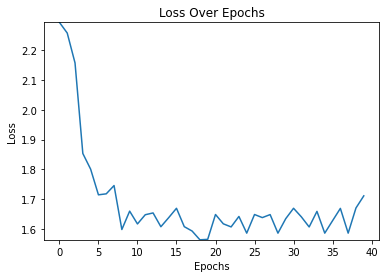

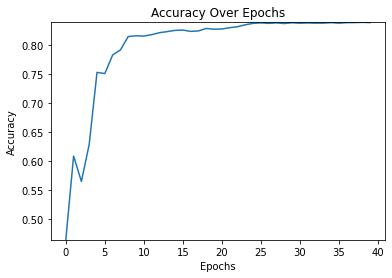

0.8378

In [196]:
best_nn.plot_loss()
best_nn.plot_accuracy()
best_nn.score(testset=testset)

## Confusion Matrix

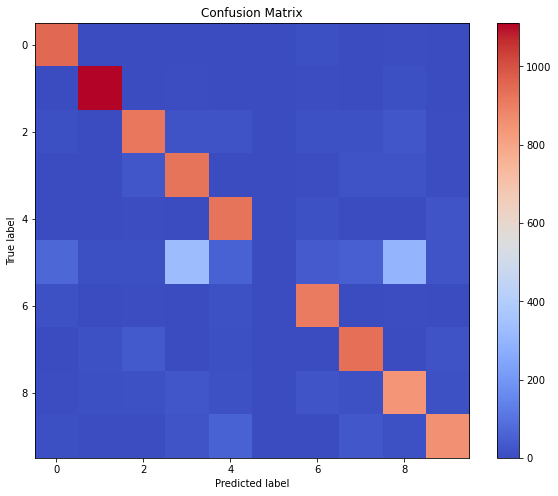

In [197]:
predictions, targets = best_nn.score(testset, return_predictions=True)
cm = confusion_matrix(targets, predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.coolwarm)
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar(fraction=0.05)
plt.show()

## Class Frequencies

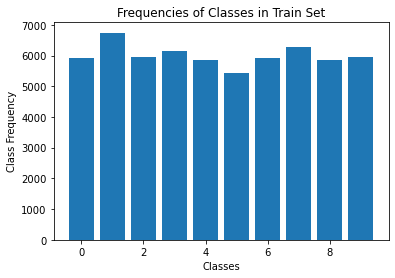

In [190]:
classes, frequencies = np.unique(trainset.targets, return_counts=True)
plt.bar(classes, frequencies)
plt.xlabel("Classes")
plt.ylabel("Class Frequency")
plt.title("Frequencies of Classes in Train Set")
plt.show()